This dataset is created specifically for binary classification, with the purpose of identifying abnormalities from un-altered scans. The ROIs for this dataset have been extract at the size in the scan and then reduced in size from 598x598 to 299x299 with no zooming in or out.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from mammo_utils import random_flip_image
import os
%matplotlib inline

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load the data
train_cbis_slices = np.load(os.path.join("data", "cbis_train_slices9.npy"))
train_cbis_labels = np.load(os.path.join("data", "cbis_train_labels9.npy"))
train_cbis_filenames = np.load(os.path.join("data", "cbis_train_names9.npy"))

test_cbis_slices = np.load(os.path.join("data", "cbis_test_slices9.npy"))
test_cbis_labels = np.load(os.path.join("data", "cbis_test_labels9.npy"))
test_cbis_filenames = np.load(os.path.join("data", "cbis_test_names9.npy"))

print("CBIS Train Images:", train_cbis_slices.shape)
print("CBIS Test Images:", test_cbis_slices.shape)

CBIS Train Images: (7290, 299, 299, 1)
CBIS Test Images: (2004, 299, 299, 1)


In [7]:
normal_slices_0 = np.load(os.path.join("data", "lumisys_slices9.npy"))
normal_labels_0 = np.load(os.path.join("data", "lumisys_labels9.npy"))

normal_slices_1 = np.load(os.path.join("data", "howtek_slices9.npy"))
normal_labels_1 = np.load(os.path.join("data", "howtek_labels9.npy"))

normal_slices_2 = np.load(os.path.join("data", "dba_slices9.npy"))
normal_labels_2 = np.load(os.path.join("data", "dba_labels9.npy"))

num_normal_images = len(normal_slices_0) + len(normal_slices_1) + len(normal_slices_2)
normal_filenames = np.repeat("NORMAL", num_normal_images)

# concatenate the data
all_normal_images = np.concatenate([normal_slices_0, normal_slices_1, normal_slices_2], axis=0)
all_normal_labels = np.concatenate([normal_labels_0, normal_labels_1, normal_labels_2], axis=0)

print("Normal Images:", all_normal_images.shape)
print("Normal Labels:", all_normal_labels.shape)

Normal Images: (95432, 299, 299, 1)
Normal Labels: (95432,)


In [8]:
# delete some variables to save memory
del(normal_slices_0, normal_slices_1, normal_slices_2)
del(normal_labels_0, normal_labels_1, normal_labels_2)

In [9]:
# in reality about 10% of mammograms are abnormal. Since I want to maximize recall I want my dataset to be skewed towards
# having slightly more abnormal images. I need to divide the normal images up between the training and testing datasets
# trying to keep the distribution within a certain range.
total_cbis_images = train_cbis_slices.shape[0] + test_cbis_slices.shape[0]
cbis_percent_train = train_cbis_slices.shape[0] / total_cbis_images
total_normal_images = all_normal_images.shape[0]

# our minimum percentage of normal images is 20%
min_normal_data_size = total_cbis_images // 0.20
min_normal_train_images = min_normal_data_size * cbis_percent_train
min_normal_test_images = min_normal_data_size * (1 - cbis_percent_train)

# our maximum number of normal images
max_number_train_normal_images = total_normal_images * cbis_percent_train
max_number_test_normal_images = total_normal_images - max_number_train_normal_images

# the min of these two sets will be the actual number of normal images we use for each dataset
target_number_train_normal_images = int(np.min([max_number_train_normal_images, min_normal_train_images]))
target_number_test_normal_images = int(np.min([max_number_test_normal_images, min_normal_test_images]))

print("Target Train Normal Images:", target_number_train_normal_images)
print("Target Test Normal Images:", target_number_test_normal_images)
print("Target Total Normal Size:", target_number_train_normal_images + target_number_test_normal_images)

print("Train Distribution:", train_cbis_slices.shape[0] / (target_number_train_normal_images + train_cbis_slices.shape[0]))
print("Test Distribution:", test_cbis_slices.shape[0] / (target_number_test_normal_images + test_cbis_slices.shape[0]))

Target Train Normal Images: 36449
Target Test Normal Images: 10019
Target Total Normal Size: 46468
Train Distribution: 0.1666704771485402
Test Distribution: 0.16668052898610997


In [10]:
# shuffle the data
all_normal_images, all_normal_labels, normal_filenames = shuffle(all_normal_images, all_normal_labels, normal_filenames, random_state=101)

# then take the appropriate number of rows
train_normal_images = all_normal_images[:target_number_train_normal_images,:,:,:]
train_normal_labels = all_normal_labels[:target_number_train_normal_images]
train_normal_filenames = normal_filenames[:target_number_train_normal_images]

test_normal_images = all_normal_images[target_number_train_normal_images:target_number_train_normal_images+target_number_test_normal_images,:,:,:]
test_normal_labels = all_normal_labels[target_number_train_normal_images:target_number_train_normal_images+target_number_test_normal_images]
test_normal_filenames = normal_filenames[target_number_train_normal_images:target_number_train_normal_images+target_number_test_normal_images]

print("Train Normal Images:", train_normal_images.shape)
print("Train Normal Labels:", train_normal_labels.shape)

print("Test Normal Images:", test_normal_images.shape)
print("Test Normal Labels:", test_normal_labels.shape)

Train Normal Images: (36449, 299, 299, 1)
Train Normal Labels: (36449,)
Test Normal Images: (10019, 299, 299, 1)
Test Normal Labels: (10019,)


In [11]:
# concatenate the ddsm and cbis data
train_images = np.concatenate([train_cbis_slices, train_normal_images], axis=0)
train_labels = np.concatenate([train_cbis_labels, train_normal_labels], axis=0)
train_filenames = np.concatenate([train_cbis_filenames, train_normal_filenames])

print("Train images:", train_images.shape)
print("Train labels:", train_labels.shape)
print("Train filenames:", train_filenames.shape)

Train images: (43739, 299, 299, 1)
Train labels: (43739,)
Train filenames: (43739,)


In [12]:
# delete old variables
del(train_cbis_slices, train_normal_images)
del(train_cbis_labels, train_normal_labels)

In [13]:
# create the test data - in order to make sure the data sets don't overlap we will splt the cbis images evenly into test
# and validation now. In order to try to segregate images by patient we will just split the data down the middle. 
# Since each mask can have at most 4 images this should keep overlap to a minimum
test_size = test_cbis_slices.shape[0] // 2

split_test_cbis_slices = test_cbis_slices[:test_size,:,:,:]
split_cv_cbis_slices = test_cbis_slices[test_size:,:,:,:]

split_test_cbis_labels = test_cbis_labels[:test_size]
split_cv_cbis_labels = test_cbis_labels[test_size:]

split_test_cbis_filenames = test_cbis_filenames[:test_size]
split_cv_cbis_filenames = test_cbis_filenames[test_size:]

print("Test Images:", split_test_cbis_slices.shape)
print("CV Images:", split_cv_cbis_slices.shape)

print("Test Labels:", split_test_cbis_labels.shape)
print("CV Labels:", split_cv_cbis_labels.shape)

Test Images: (1002, 299, 299, 1)
CV Images: (1002, 299, 299, 1)
Test Labels: (1002,)
CV Labels: (1002,)


In [14]:
from sklearn.model_selection import train_test_split

# now shuffle and split the normal images 
split_test_normal_images, split_cv_normal_images, split_test_normal_labels, split_cv_normal_labels, split_test_normal_filenames, split_cv_normal_filenames  = train_test_split(test_normal_images, test_normal_labels, test_normal_filenames, test_size=0.5)

# concatentate the data
test_images = np.concatenate([split_test_cbis_slices, split_test_normal_images], axis=0)
test_labels = np.concatenate([split_test_cbis_labels, split_test_normal_labels], axis=0)
test_filenames = np.concatenate([split_test_cbis_filenames, split_test_normal_filenames])

print("Test images:", test_images.shape)
print("Test labels:", test_labels.shape)
print("Test filenames:", test_filenames.shape)

# concatentate the data
cv_images = np.concatenate([split_cv_cbis_slices, split_cv_normal_images], axis=0)
cv_labels = np.concatenate([split_cv_cbis_labels, split_cv_normal_labels], axis=0)
cv_filenames = np.concatenate([split_cv_cbis_filenames, split_cv_normal_filenames])

print("CV images:", cv_images.shape)
print("CV labels:", cv_labels.shape)
print("CV filenames:", cv_filenames.shape)

Test images: (6011, 299, 299, 1)
Test labels: (6011,)
Test filenames: (6011,)
CV images: (6012, 299, 299, 1)
CV labels: (6012,)
CV filenames: (6012,)


In [15]:
# delete old vars
del(test_cbis_slices, test_normal_images)

In [16]:
# encode the labels
le = preprocessing.LabelEncoder()
le.fit(train_labels)
# we want normal to be 0, so we'll do some transformations here
train_labels_enc = le.transform(np.array(train_labels)) + 1
train_labels_enc[train_labels_enc == 5] = 0

# encode the test labels
test_labels_enc = le.transform(np.array(test_labels)) + 1
test_labels_enc[test_labels_enc == 5] = 0

# encode the cv labels
cv_labels_enc = le.transform(np.array(cv_labels)) + 1
cv_labels_enc[cv_labels_enc == 5] = 0

# make the classes be in the same order as the labels
classes = le.classes_
classes = np.insert(classes, 0, 'NORMAL', axis=0)
classes = classes[0:5]

# make some other labels
labels_normal = np.zeros(len(train_labels_enc)).astype(np.int32)
labels_normal[train_labels_enc != 0] = 1

np.save(os.path.join("data", "all_classes.npy"), classes)

### Check the distribution of the training data

In [17]:
pd.value_counts(train_labels_enc, normalize=True)

0    0.833330
1    0.048081
2    0.043691
4    0.041428
3    0.033471
dtype: float64

In [18]:
pd.value_counts(labels_normal, normalize=True)

0    0.83333
1    0.16667
dtype: float64

## Shuffle the data and split it

In [19]:
# shuffle the training data
X_tr, y_tr, train_filenames, labels_normal = shuffle(train_images, train_labels_enc, train_filenames, labels_normal, random_state=7241972)

# shuffle the test data
X_te, y_te, test_filenames = shuffle(test_images, test_labels_enc, test_filenames, random_state=228859)

# shuffle the cv data
X_cv, y_cv, cv_filenames = shuffle(cv_images, cv_labels_enc, cv_filenames, random_state=21777)


print("X_tr", X_tr.shape)
print("X_te", X_te.shape)
print("X_cv", X_cv.shape)

X_tr (43739, 299, 299, 1)
X_te (6011, 299, 299, 1)
X_cv (6012, 299, 299, 1)


### Check the distribution of the test data

In [20]:
pd.value_counts(y_te, normalize=True)

0    0.833306
2    0.100815
4    0.065879
dtype: float64

In [21]:
pd.value_counts(y_cv, normalize=True)

0    0.833333
1    0.092814
3    0.061377
4    0.006487
2    0.005988
dtype: float64

In [22]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [23]:
# write train data to tfrecords in 5 batches
import math
num_batches = 5
batch_size = math.ceil(X_tr.shape[0] / num_batches)

for i in range(num_batches):
    train_path = os.path.join("data","training9_" + str(i) + '.tfrecords')
    writer = tf.python_io.TFRecordWriter(train_path)
    start_row = i * batch_size
    end_row = start_row + batch_size - 1
                              
    for idx in range(start_row, end_row):
        # try to get the data, if there is an error skip this index
        try:
            label = y_tr[idx]
            label_normal = labels_normal[idx]
            filename = train_filenames[idx].tostring()
            image = X_tr[idx]
            image_raw = image.tostring()
        except:
            continue
            
        example = tf.train.Example(
            features=tf.train.Features(
              feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'label': _int64_feature(label),
                'label_normal': _int64_feature(label_normal),
                'filename': _bytes_feature(filename),
                'image': _bytes_feature(image_raw),
              }))

        # use the proto object to serialize the example to a string
        serialized = example.SerializeToString()
        # write the serialized object to disk
        writer.write(serialized)

In [24]:
## save the test data
np.save(os.path.join("data", "test9_data.npy"), X_te)
np.save(os.path.join("data", "test9_labels.npy"), y_te)
np.save(os.path.join("data", "test9_filenames.npy"), test_filenames)

In [25]:
# save the validation data
np.save(os.path.join("data", "cv9_data.npy"), X_cv)
np.save(os.path.join("data", "cv9_labels.npy"), y_cv)
np.save(os.path.join("data", "cv9_filenames.npy"), cv_filenames)

In [ ]:
# Normalize the test data since apparently tfrecords normalizes image data
X_te = np.load(os.path.join("data", "test9_data.npy"))
X_cv = np.load(os.path.join("data", "test9_data.npy"))

# we'll use the pre-calculated mean and std of the data
mu = 104.1353
sigma = 

X_te = (X_te - mu) / sigma
X_cv = (X_cv - mu) / sigma

print("Max:", np.max(X_te))
print("Min:", np.min(X_te))
print("Mean:", np.mean(X_te))

In [ ]:
# save the data
np.save(os.path.join("data", "cv9_data.npy"), X_cv)
np.save(os.path.join("data", "test9_data.npy"), X_te)

## Verify that the data was written correctly

In [26]:
# make sure everything was written properly by reading it back out
def read_and_decode_single_example(filenames):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string)
        })
    
    # now return the converted data
    label = features['label']
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])
    
    # scale the image
    image = tf.image.per_image_standardization(image)
    
    # random flip image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    #image = tf.image.random_brightness(image, max_delta=10)
    #image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    
    return label, image

In [27]:
label, image = read_and_decode_single_example(["data/training9_0.tfrecords", "data/training9_1.tfrecords"])

#images_batch, labels_batch = tf.train.shuffle_batch([image, label], batch_size=16, capacity=2000, min_after_dequeue=1000)
images_batch, labels_batch = tf.train.batch([image, label], batch_size=16, capacity=2000)

# class_weight = tf.constant([4.0,1.0,1.0,1.0, 1.0])
# weight_per_label = tf.transpose(tf.matmul(tf.cast(tf.one_hot(labels_batch, depth=5), tf.float32), tf.transpose(class_weight)))

global_step = tf.Variable(0, trainable=False)

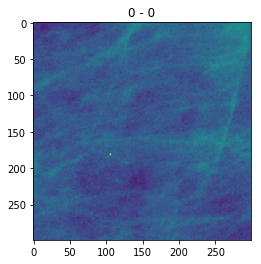

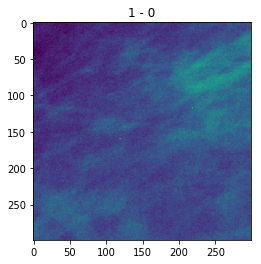

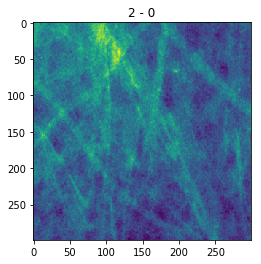

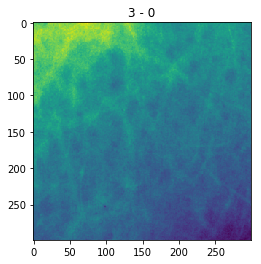

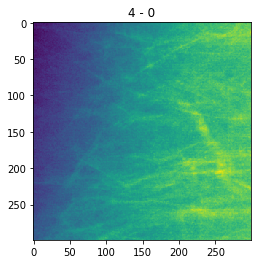

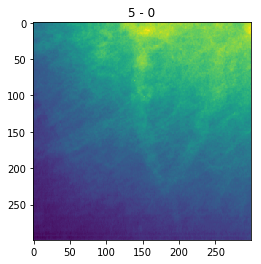

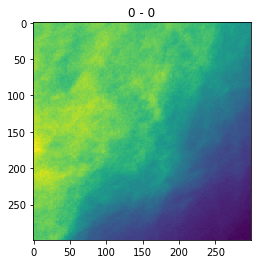

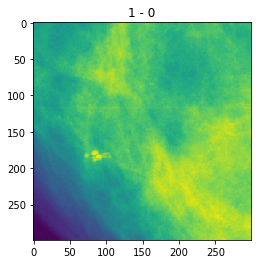

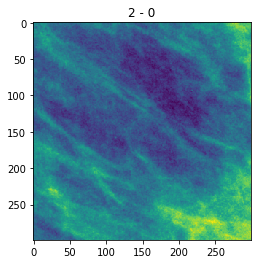

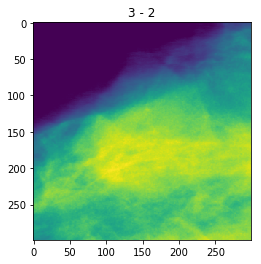

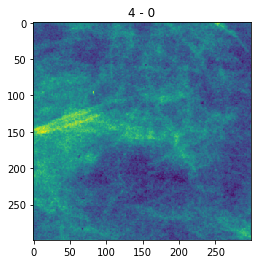

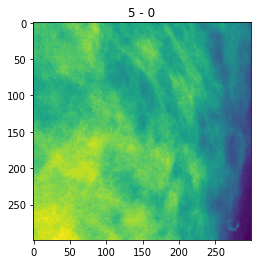

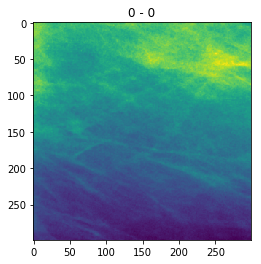

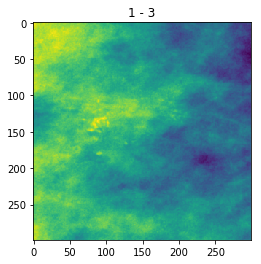

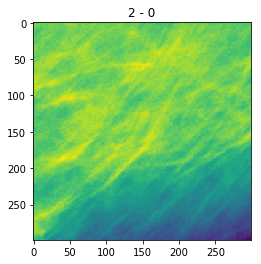

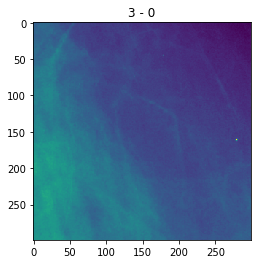

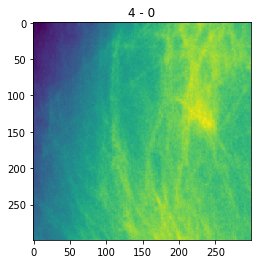

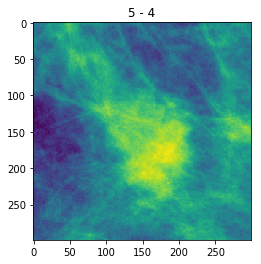

In [28]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for j in range(3):
        la_b, im_b = sess.run([labels_batch, images_batch])
        
        for i in range(6):
            plt.imshow(im_b[i].reshape([299,299]))
            plt.title(str(i) + " - " + str(la_b[i]))
            plt.show()

    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)